## Section 5.3: Mass-Metallicity relation

In [1]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz, cm
from astropy.cosmology import LambdaCDM
import pandas as pd
from schwimmbad import MultiPool
from scipy.stats import gaussian_kde
from lmfit import Model

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
    O2b,
    O2r,
    O3r,
    O3b,
    O3,
)
from synthesizer.conversions import lnu_to_absolute_mag

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmasher as cmr

from utilities import (
    binned_weighted_quantile, 
    compute_metallicity_dust_correction,
)

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)
plt.style.use('styles/style.mplstyle')

# Set the random seed for reproducibility
np.random.seed(680010)

In [2]:
def get_data(
    ii,
    tag,
    mstarlimit=1e8,
    OIIIlimit=1e-17*erg/s/cm**2,
    cosmo=cosmo
    ):
    """Helper function to load in the relevatn FLARES data.
    
    Args:
        ii (int): The index of the simulation to load.
        tag (str): The tag of the simulation to load.
        mstarlimit (float, optional): The minimum stellar mass to consider. Defaults to 1e8 Msun.
        OIIIlimit (float, optional): The minimum OIII5007 flux to consider. Defaults to 1e-17 erg/s/cm^2.
        cosmo (astropy.cosmology, optional): The cosmology to use for distance calculations. Defaults to the LambdaCDM cosmology defined above.
        
    Returns:
        tuple: A tuple containing the following arrays with OIII5007 flux greater than the specified limit and stellar mass greater than the specified limit:
            - Mstar: The stellar mass of the galaxies.
            - MFUVatt: The FUV absolute magnitude of the galaxies after dust attenuation.
            - Halpha: The Halpha luminosity of the galaxies after dust attenuation.
            - OIII5007: The OIII5007 luminosity of the galaxies after dust attenuation.
            - OIII4959: The OIII4959 luminosity of the galaxies after dust attenuation.
            - OII3727: The OII3727 luminosity of the galaxies after dust attenuation.
            - NeIII3869: The NeIII3869 luminosity of the galaxies after dust attenuation.
            - OIII5007int: The intrinsic OIII5007 luminosity of the galaxies.
            - OIII4959int: The intrinsic OIII4959 luminosity of the galaxies.
            - OII3727int: The intrinsic OII3727 luminosity of the galaxies.
            - NeIII3869int: The intrinsic NeIII3869 luminosity of the galaxies.
            - Hbeta: The Hbeta luminosity of the galaxies after dust attenuation.
            - Halphaint: The intrinsic Halpha luminosity of the galaxies.
            - Hbetaint: The intrinsic Hbeta luminosity of the galaxies.
            - MassweightedZ: The mass-weighted metallicity of the galaxies.
            - Av: The V-band attenuation of the galaxies.
            - HbetaEW: The equivalent width of the Hbeta line after dust attenuation.
    """

    z = float(tag[5:].replace('p','.'))
    
    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_shared_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('MassWeightedYoungStellarZ'), dtype = np.float64)
        MFUVatt = lnu_to_absolute_mag(np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz)

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        HbetaEW = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('EW'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)

        OIII5007 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OIII5007'].get('Luminosity'), dtype = np.float64)
        OIII4959 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OIII4959'].get('Luminosity'), dtype = np.float64)
        OII3727 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OII3726'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/OII3729'].get('Luminosity'), dtype = np.float64)
        NeIII3869 = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/NeIII3869'].get('Luminosity'), dtype = np.float64)

        OIII5007int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OIII5007'].get('Luminosity'), dtype = np.float64)
        OIII4959int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OIII4959'].get('Luminosity'), dtype = np.float64)
        OII3727int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OII3726'].get('Luminosity'), dtype = np.float64) + np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/OII3729'].get('Luminosity'), dtype = np.float64)
        NeIII3869int = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/NeIII3869'].get('Luminosity'), dtype = np.float64)

    lum_dist = cosmo.luminosity_distance(z).to("cm").value * cm
    OIII5007flux = OIII5007 * (erg/s) * (1+z) / (4 * np.pi * lum_dist**2)

    ok = (Halphaint>0) * (Mstar>mstarlimit) * (OIII5007flux>=OIIIlimit)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], OIII5007[ok], OIII4959[ok], OII3727[ok], NeIII3869[ok], OIII5007int[ok], OIII4959int[ok], OII3727int[ok], NeIII3869int[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], Av[ok], HbetaEW[ok]

In [3]:
# Define the synthesizer grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/"
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014

# Define the required lines and filters
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

# Define the tophat filters
tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

# Define the filter collection
filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

# Define the lines we want to use in our analysis
li = [
       Ha,
       Hb, 
       O2b,
       O2r,
       O3r,
       O3b,
       O3,
       'Ne 3 3868.76A'
   ]

### Create toy model galaxies 
(Same across all notebooks)

In [4]:
# An arbitrary redshift to use for the analysis
redshift = 6.

# Number of star particles
n = 100
ages = 10**np.random.uniform(0, np.log10(50), size=n) * Myr
Z = 10**np.random.uniform(-3.5, -2., size=n)
mass = 1e6*np.random.uniform(2, 5, n) * Msun 

# Dust distributions
# We want to explore the impact of varying the dust distribution
# on observed line luminosities and ratios. We do this by drawing
# tau_v values from a normal distribution with mean 0.3 and sigma 0.4,
# and then scaling the sigma by different factors to create different
# dust distributions. We also set a maximum tau_v value of 7 to avoid
# unphysically high values. We also creat 4 different toy galaxies with
# the same average proeprties, but varying first the dust distribution,
# then the age distribution, then the metallicity distribution, and
# finally all properties together.
max_tau = 7
mu, sigma = 0.3, 0.4
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)
colors = cmr.take_cmap_colors('cmr.gem_r', num_gals, return_fmt='rgb')

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
Av = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

# print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

tau_v = np.zeros((num_gals, n))
for ii in range(num_gals):
    tmp  = mu + np.random.normal(0, sigma*nsigma[ii], n)
    tmp[tmp<0] = 0.01
    tau_v[ii] = tmp

for jj, kk in enumerate(all_gals):
    # print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):
        
        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v[ii],
            dust_curve=PowerLaw(),
            per_particle=True
        )    
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
# print (Av)
# print (logOH)
# print (np.log10(np.sum(mass)))

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/450393097.py:40: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/450393097.py:53: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_const.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/450393097.py:61: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_age.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/450393097.py:69: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_Z.load_stars(
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


# Line ratios

<!-- $S2 = [SII]\lambda 6716,31 / H_{\alpha}$ -->

$R3 = [OIII]\lambda 5007/ H_{\beta}$

$R2 = [OII]\lambda 3727,29/H_{\beta}$

$R23 = \dfrac{[OIII]\lambda 4959,5007 + [OII]\lambda 3727,29}{H_{\beta}}$

$O32 = [OIII]\lambda5007/[OII]\lambda3727,29$

$Ne3O2 = [NeIII]\lambda3869/[OII]\lambda 3727,29$

In [5]:
line_gals_int, line_gals_att = {}, {}

for jj, kk in enumerate(all_gals):
    
    tmp = {value: line_int[jj][key].luminosity.sum() for key, value in req_lines.items()}
    tmp['R23'] = (tmp['[OIII]4959']+tmp['[OIII]5007']+tmp['[OII]3727,29'])/tmp['Hbeta']
    tmp['R3'] = tmp['[OIII]5007']/tmp["Hbeta"]
    tmp['Ne3O2'] = tmp['NeIII3869']/tmp['[OII]3727,29']
    tmp['O32'] = tmp['[OIII]5007']/tmp['[OII]3727,29']
    
    if jj==0:
        line_gals_int = {jj: tmp}    
    else:
        line_gals_int[jj] = tmp   

    for ii in range(num_gals):
        
        tmp = {value: line_emergent[jj][ii][key].luminosity.sum() for key, value in req_lines.items()}
        tmp['R23'] = (tmp['[OIII]4959']+tmp['[OIII]5007']+tmp['[OII]3727,29'])/tmp['Hbeta']
        tmp['R3'] = tmp['[OIII]5007']/tmp["Hbeta"]
        tmp['Ne3O2'] = tmp['NeIII3869']/tmp['[OII]3727,29']
        tmp['O32'] = tmp['[OIII]5007']/tmp['[OII]3727,29']
        tmp['R2'] = tmp['[OII]3727,29']/tmp["Hbeta"]
        if ii==0:
            line_gals_att[jj] = {ii: tmp}    
        else:
            line_gals_att[jj][ii] = tmp        


#### Derived metallicities of the toy galaxies

Figure 10 in paper

<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/785542041.py:58: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[1].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='upper left', framealpha=0.2)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/785542041.py:61: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[2].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='upper right', framealpha=0.2, fontsize=11)


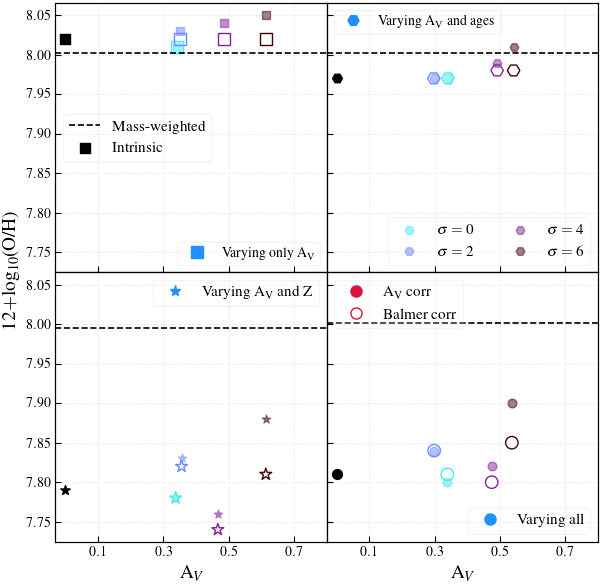

In [6]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(7, 7), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
twinaxs = [ax.twinx() for ax in axs]

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]
custom_att = [Line2D([], [], marker='o', markersize=8, color='crimson', linestyle='None', markerfacecolor=ii) for ii in ['crimson', 'None']]

for ii in range(4):
    if ii==0:
        axs[ii].axhline(y=logOH[ii], label='Mass-weighted', color='black', ls='dashed')
    else:
        axs[ii].axhline(y=logOH[ii], color='black', ls='dashed')


# Varying only Av
axs[0].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[0], Balmerdust=False, Sanders=False, Curti=True)[0], color='black', s=50, marker=markers[0], label='Intrinsic')

# Varying Av and ages
axs[1].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[1], Balmerdust=False, Sanders=False, Curti=True)[0], color='black', s=50, marker=markers[1])

# Varying Av and Z
axs[2].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[2], Balmerdust=False, Sanders=False, Curti=True)[0], color='black', s=50, marker=markers[2])

# Varying all
axs[3].scatter(0.0, compute_metallicity_dust_correction(line_gals_int[3], Balmerdust=False, Sanders=False, Curti=True)[0], color='black', s=50, marker=markers[3])

for jj in range(4):

    for ii in range(num_gals):
        
        axs[jj].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii], Sanders=False, Curti=True)[0], edgecolor=colors[ii], facecolor='None', s=80, marker=markers[jj])  

        if jj==1:
            axs[jj].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii], Balmerdust=False, Avdust=True, Av=Av[jj][ii], Sanders=False, Curti=True)[0], color=colors[ii], s=40, marker=markers[jj], alpha=0.5, label=rF'$\sigma={nsigma[ii]}$') 
        else:
            axs[jj].scatter(Av[jj][ii], compute_metallicity_dust_correction(line_gals_att[jj][ii], Balmerdust=False, Avdust=True, Av=Av[jj][ii], Sanders=False, Curti=True)[0], color=colors[ii], s=40, marker=markers[jj], alpha=0.5)             

for ax in axs:
    ax.grid(ls='dotted', alpha=0.5)
    ax.set_xticks(np.arange(0.1,1,0.2))
    ax.set_xlim(-0.03,0.8)
    # ax.set_ylim(7.01, 9.1)

for ax in twinaxs:
    ax.set_xlim(-0.03,0.8)
    # ax.set_ylim(7.01, 9.1)
    ax.set_yticks([])
    ax.set_yticklabels([])

axs[-1].set_xlabel(r'A$_{V}$', fontsize=14)
axs[-2].set_xlabel(r'A$_{V}$', fontsize=14)


twinaxs[0].legend([custom[0]], [r'Varying only A$_{\mathrm{V}}$'], loc='lower right', framealpha=0.2)
axs[0].legend(frameon=True, loc='center left', framealpha=0.2, fontsize=11)

twinaxs[1].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='upper left', framealpha=0.2)
axs[1].legend(frameon=True, loc='lower right', ncols=2, framealpha=0.2, fontsize=11)

twinaxs[2].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='upper right', framealpha=0.2, fontsize=11)

twinaxs[3].legend([custom[3]], ['Varying all'], loc='lower right', framealpha=0.2, fontsize=11)
axs[3].legend(custom_att, [r'A$_{\rm V}$ corr', r'Balmer corr'], frameon=True, fontsize=11, loc='upper left', framealpha=0.2)

fig.text(0.05, 0.5, r'$12+$log$_{10}$(O/H)', va='center', fontsize=14, rotation='vertical')

# fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0.)

plt.savefig('plots/toy_met_Av.png', dpi=300)
plt.show()   

In [7]:
def flares_galaxies(ii, func, data):
    """Function to package FLARES line luminosities into dictionaries.
    
    Args:
        ii (int): The index of the galaxy to load.
        func (function): The function to apply to the line luminosities.
        data (tuple): A tuple containing the line luminosities and other properties of the galaxies.
        
    Returns:
        The output of the function applied to the line luminosities and other properties of the galaxy, here the strong-line metallicity with different dust corrections applied.
    """
    
    Halpha, Hbeta, OII3727, OIII4959, OIII5007, NeIII3869, Av, HbetaEW = data
    
    gal = {}
    gal['Av'] = Av[ii]
    gal['HbetaEW'] = HbetaEW
    gal['Halpha'] = Halpha[ii]
    gal['Hbeta'] = Hbeta[ii]
    gal['[OII]3727,29'] = OII3727[ii]
    gal['[OIII]4959'] = OIII4959[ii]
    gal['[OIII]5007'] = OIII5007[ii]
    gal[ 'NeIII3869'] = NeIII3869[ii]
    
    gal['R23'] = (gal['[OIII]4959']+gal['[OIII]5007']+gal['[OII]3727,29'])/gal['Hbeta']
    gal['R3'] = gal['[OIII]5007']/gal["Hbeta"]
    gal['R2'] = gal['[OII]3727,29']/gal["Hbeta"]
    gal['Ne3O2'] = gal['NeIII3869']/gal['[OII]3727,29']
    gal['O32'] = gal['[OIII]5007']/gal['[OII]3727,29']
    
    out = func(gal)
    
    return out

def get_flares_galZ(data_att, data_int, tot_gals):    
    """Helper functions to get the FLARES strong-line metallicities.
    
    Args:
        data_att (tuple): A tuple containing the line luminosities and other properties of the galaxies
        data_int (tuple): A tuple containing the line luminosities and other properties of the galaxies without dust correction
        tot_gals (int): The total number of galaxies to process
    
    Returns:
        tuple: A tuple containing the following arrays with OIII5007 flux greater than the specified limit and stellar mass greater than the specified limit:
            - flares_dust_corr_Z: The strong-line metallicity of the galaxies with dust correction applied.
            - flares_Avdust_corr_Z: The strong-line metallicity of the galaxies with only Av dust correction applied.
            - flares_int_dust_corr_Z: The strong-line metallicity of the galaxies without any dust correction applied.
    """
    
    f = partial(compute_metallicity_dust_correction, Avdust=False, Balmerdust=True, Sanders=False, Curti=True)
    flares_dust_corr_Z = np.array([flares_galaxies(ii, f, data_att) for ii in range(tot_gals)])[:,0]
    
    f = partial(compute_metallicity_dust_correction, Avdust=True, Balmerdust=False, Sanders=False, Curti=True)
    flares_Avdust_corr_Z = np.array([flares_galaxies(ii, f, data_att) for ii in range(tot_gals)])[:,0]
    
    
    f = partial(compute_metallicity_dust_correction, Balmerdust=False, Sanders=False, Curti=True)
    flares_int_dust_corr_Z = np.array([flares_galaxies(ii, f, data_int) for ii in range(tot_gals)])[:,0]

    return np.asarray(flares_dust_corr_Z, dtype=np.float32), np.asarray(flares_Avdust_corr_Z, dtype=np.float32), np.asarray(flares_int_dust_corr_Z, dtype=np.float32)

### Derive FLARES strong-line metallicties using the Curti+2023 method

In [8]:
tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

quantiles = [0.01,0.16,0.50,0.84,0.99]
OIIIlimit = 3e-18 * erg/s/cm**2

mbins = np.arange(8.,11.5,0.3)
mbincen = (mbins[1:] + mbins[:-1])/2.

lbins = -np.arange(17., 24.5, 0.5)[::-1]
lbincen = (lbins[1:] + lbins[:-1])/2.

data_lines = {}
data_mass = {}
data_luv = {}
met_data = {}

for ii, tag in enumerate(tags):

    z = float(tag[5:].replace('p','.'))

    func    = partial(get_data, tag=tag, OIIIlimit=OIIIlimit, cosmo=cosmo)
    pool    = MultiPool(processes=8)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()


    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    OIII5007 = np.concatenate(dat[:,3])
    OIII4959 = np.concatenate(dat[:,4])
    OII3727 = np.concatenate(dat[:,5])
    NeIII3869 = np.concatenate(dat[:,6])
    OIII5007int = np.concatenate(dat[:,7])
    OIII4959int = np.concatenate(dat[:,8])
    OII3727int = np.concatenate(dat[:,9])
    NeIII3869int = np.concatenate(dat[:,10])
    Hbeta = np.concatenate(dat[:,11])
    Halphaint = np.concatenate(dat[:,12])
    Hbetaint = np.concatenate(dat[:,13])
    MassweightedZ = 8.69 + np.log10(np.concatenate(dat[:,14])/Zsun)
    Av = np.concatenate(dat[:,15])
    HbetaEW = np.concatenate(dat[:,16])

    tot_gals = len(Mstar)

    data_att = (Halpha, Hbeta, OII3727, OIII4959, OIII5007, NeIII3869, Av, HbetaEW)
    data_int = (Halphaint, Hbetaint, OII3727int, OIII4959int, OIII5007int, NeIII3869int, Av, HbetaEW)
    
    data_lines[F'R23_z{z}'] = (OIII5007+OIII4959+OII3727)/Hbeta
    data_lines[F'R3_z{z}'] = OIII5007/Hbeta
    data_lines[F'O32_z{z}'] = OIII5007/OII3727
    data_lines[F'Ne3O2_z{z}'] = NeIII3869/OII3727
    
    data_lines[F'intR23_z{z}'] = (OIII5007int+OIII4959int+OII3727int)/Hbetaint
    data_lines[F'intR3_z{z}'] = OIII5007int/Hbetaint
    data_lines[F'intO32_z{z}'] = OIII5007int/OII3727int
    data_lines[F'intNe3O2_z{z}'] = NeIII3869int/OII3727int

    
    flares_dust_corr_Z, flares_Avdust_corr_Z, flares_int_dust_corr_Z = get_flares_galZ(data_att, data_int, tot_gals)

    met_data[F'dustcorr_z{z}'] = flares_dust_corr_Z
    met_data[F'avdustcorr_z{z}'] = flares_Avdust_corr_Z
    met_data[F'intdustcorr_z{z}'] = flares_int_dust_corr_Z
    met_data[F'massweighted_z{z}'] = MassweightedZ
    met_data[F'mstar_z{z}'] = Mstar

    ws = np.zeros(tot_gals)
    n = 0
    for jj in range(40):
        if jj==0:
            ws[0:len(dat[jj][0])] = weights[jj]
        else:
            ws[n:n+len(dat[jj][0])] = weights[jj]

        n+=len(dat[jj][0])
    
    # Mass bins    
    hist, edges = np.histogram(Mstar, mbins)
    data_mass[F'N_z{z}'] = hist
    
    tmp = binned_weighted_quantile(Mstar, MassweightedZ, ws, mbins, quantiles)
    data_mass[F'massweighted_z{z}'] = tmp.T    
    
    tmp = binned_weighted_quantile(Mstar, flares_int_dust_corr_Z, ws, mbins, quantiles)
    data_mass[F'intdustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(Mstar, flares_dust_corr_Z, ws, mbins, quantiles)
    data_mass[F'dustcorr_z{z}'] = tmp.T
    tmp = binned_weighted_quantile(Mstar, flares_Avdust_corr_Z, ws, mbins, quantiles)
    data_mass[F'avdustcorr_z{z}'] = tmp.T
    

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/1273255319.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/1273255319.py:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
/v

#### FLARES MZR

Figure 11 in paper

<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/972108076.py:39: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=15)


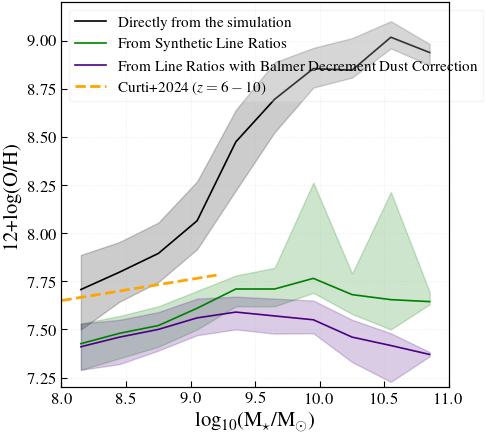

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 5), sharex=False, sharey=True, facecolor='w', edgecolor='k')
twinax = ax.twinx()

labels = ['Intrinsic (mass-weighted)', 'Intrinsic (line ratio)', 'Balmer corr', 'Av corr']

colors = ['black', 'green', 'indigo', 'red']

# z = 6
tag = tags[1]
z = float(tag[5:].replace('p','.'))

ok = np.where(data_mass[F'N_z{z}']>5)[0]

ax.plot(mbincen[ok], data_mass[F'massweighted_z{z}'][2][ok], color=colors[0], label='Directly from the simulation')
ax.fill_between(mbincen[ok], data_mass[F'massweighted_z{z}'][1][ok], data_mass[F'massweighted_z{z}'][3][ok], color=colors[0], alpha=0.2)

ax.plot(mbincen[ok], data_mass[F'intdustcorr_z{z}'][2][ok], color=colors[1], label='From Synthetic Line Ratios')
ax.fill_between(mbincen[ok], data_mass[F'intdustcorr_z{z}'][1][ok], data_mass[F'intdustcorr_z{z}'][3][ok], color=colors[1], alpha=0.2)

ax.plot(mbincen[ok], data_mass[F'dustcorr_z{z}'][2][ok], color=colors[2], label='From Line Ratios with Balmer Decrement Dust Correction')
ax.fill_between(mbincen[ok], data_mass[F'dustcorr_z{z}'][1][ok], data_mass[F'dustcorr_z{z}'][3][ok], color=colors[2], alpha=0.2)


ax.plot(mbins[mbins<9.5], 0.11 * (mbins[mbins<9.5]-8) + 7.65, ls='dashed', label='Curti+2024 ($z=6-10$)', color='orange', lw=2)

ax.set_xlim(8, 11.)

ax.grid(ls='dashed')
twinax.set_yticks([])
twinax.set_yticklabels([])    
ax.grid(ls='dotted')    
ax.set_ylim(7.2, 9.2)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

ax.legend(fontsize=11, frameon=True, framealpha=0.2, loc='upper left')
    
ax.set_ylabel('12+log(O/H)', fontsize=15)      
ax.set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=15)

    
fig.subplots_adjust(hspace=0.2,wspace=0)
# plt.savefig(F'plots/line_ratio_mzr_z{int(z)}.png', dpi=300, bbox_inches='tight')

#### Derive the parameters for the FLARES MZR
Fitting funciton of the form: 12 + log(O/H) = beta * log(Mstar/(1e8 Msun)) + Zm8

In [10]:
#Metallicity fit
def mzr_fit_fn(mstar, beta, Zm8):
    
    return beta * (mstar-8) + Zm8

def fit_mzr(mstar, met):
    
    model = Model(mzr_fit_fn)

    model.set_param_hint('beta', min=0.0, max=1)
    model.set_param_hint('Zm8', min=6.5, max=8.5)

    result = model.fit(met, mstar=mstar, beta=0.1, Zm8=7.5, method='emcee', fit_kws={'steps':4000, 'burn':2000, 'nwalkers':200, 'thin':20})
    
    return result

z = 6.0
ok = np.where(met_data[F'mstar_z{z}']<=9.5)[0]
for val in [F'dustcorr_z{z}', F'avdustcorr_z{z}', F'intdustcorr_z{z}', F'massweighted_z{z}']:

    result = fit_mzr(met_data[F'mstar_z{z}'][ok], met_data[val][ok])
    print (val, result.fit_report())

100%|██████████| 4000/4000 [00:35<00:00, 113.80it/s]


dustcorr_z6.0 [[Model]]
    Model(mzr_fit_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12563
    # variables        = 2
    chi-square         = 231.754548
    reduced chi-square = 0.01845033
    Akaike info crit   = -50157.9539
    Bayesian info crit = -50143.0769
    R-squared          = 0.15654023
[[Variables]]
    beta:  0.16722173 +/- 0.02558431 (15.30%) (init = 0.1)
    Zm8:   7.36500246 +/- 0.01470445 (0.20%) (init = 7.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, Zm8) = -0.7958


100%|██████████| 4000/4000 [00:32<00:00, 122.57it/s]


avdustcorr_z6.0 [[Model]]
    Model(mzr_fit_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12563
    # variables        = 2
    chi-square         = 224.759203
    reduced chi-square = 0.01789342
    Akaike info crit   = -50542.9999
    Bayesian info crit = -50528.1229
    R-squared          = 0.15552096
[[Variables]]
    beta:  0.16449057 +/- 0.02540317 (15.44%) (init = 0.1)
    Zm8:   7.36248355 +/- 0.01465630 (0.20%) (init = 7.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, Zm8) = -0.8000


100%|██████████| 4000/4000 [00:30<00:00, 131.25it/s]


intdustcorr_z6.0 [[Model]]
    Model(mzr_fit_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12563
    # variables        = 2
    chi-square         = 226.904607
    reduced chi-square = 0.01806422
    Akaike info crit   = -50423.6504
    Bayesian info crit = -50408.7734
    R-squared          = 0.24597571
[[Variables]]
    beta:  0.21992411 +/- 0.02533616 (11.52%) (init = 0.1)
    Zm8:   7.36431222 +/- 0.01478493 (0.20%) (init = 7.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, Zm8) = -0.7992


100%|██████████| 4000/4000 [00:31<00:00, 126.73it/s]


massweighted_z6.0 [[Model]]
    Model(mzr_fit_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12563
    # variables        = 2
    chi-square         = 437.172409
    reduced chi-square = 0.03480395
    Akaike info crit   = -42184.8608
    Bayesian info crit = -42169.9838
    R-squared          = 0.43902945
[[Variables]]
    beta:  0.47246039 +/- 0.02572009 (5.44%) (init = 0.1)
    Zm8:   7.59700133 +/- 0.01471280 (0.19%) (init = 7.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, Zm8) = -0.8030


#### Redshift evolution of the MZR

Figure 12 in paper

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_33162/3798560932.py:41: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=14)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


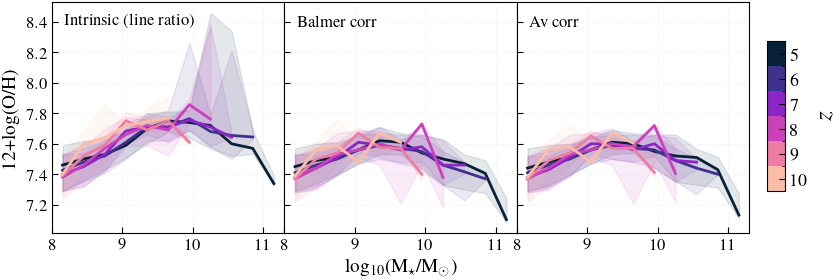

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(9, 3), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs=axs.ravel()


labels = ['Intrinsic (line ratio)', 'Balmer corr', 'Av corr']

c_m =plt.get_cmap('cmr.bubblegum')
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,6,1), c_m.N)
# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

for ii, tag in enumerate(tags):
    
    z = float(tag[5:].replace('p','.'))
    
    ok = np.where(data_mass[F'N_z{z}']>5)[0]
    
    
    axs[0].plot(mbincen[ok], data_mass[F'intdustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[0].fill_between(mbincen[ok], data_mass[F'intdustcorr_z{z}'][1][ok], data_mass[F'intdustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)    
    
    
    axs[1].plot(mbincen[ok], data_mass[F'dustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[1].fill_between(mbincen[ok], data_mass[F'dustcorr_z{z}'][1][ok], data_mass[F'dustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
    axs[2].plot(mbincen[ok], data_mass[F'avdustcorr_z{z}'][2][ok], color=s_m.to_rgba(ii), lw=2, zorder=10)
    axs[2].fill_between(mbincen[ok], data_mass[F'avdustcorr_z{z}'][1][ok], data_mass[F'avdustcorr_z{z}'][3][ok], color=s_m.to_rgba(ii), alpha=0.1, zorder=1)
    
for ii in range(3):
    axs[ii].legend(title=labels[ii], frameon=False, title_fontsize=12, loc='upper left')

    axs[ii].grid(ls='dotted')    
    # axs[jj].set_ylim(7.4, 8.5)
    for label in (axs[ii].get_xticklabels() + axs[ii].get_yticklabels()):
        label.set_fontsize(12)
    

axs[0].set_ylabel('12+log(O/H)', fontsize=14)  

axs[1].set_xlabel('log$_{10}$(M$_{\star}$/M$_{\odot}$)', fontsize=14)

cbaxes = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(s_m, cax=cbaxes)
cbar.set_label(r'$z$', fontsize = 18)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(np.arange(5,11))
cbaxes.invert_yaxis()
for label in cbaxes.get_yticklabels():
    label.set_fontsize(13)

fig.subplots_adjust(hspace=0,wspace=0)    
plt.savefig(F'plots/line_ratio_mzr_z_evo.png', dpi=300, bbox_inches='tight')